In [1]:
# @title Cell 1: Introduction and Setup
# ==============================================================================
#                      SUPPLEMENTARY EVIDENCE NOTEBOOK
# ==============================================================================
# This notebook contains the code to generate the foundational experimental
# results presented in Sections 2 and 3 of the main paper. Each section is
# self-contained and can be run independently.
# ==============================================================================

# --- Install all necessary libraries ---
!pip install -q yfinance pandas numpy matplotlib tqdm statsmodels

# --- Import all modules ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("✅ Setup complete.")

✅ Setup complete.


--- Generating Figure for Section 2 ---


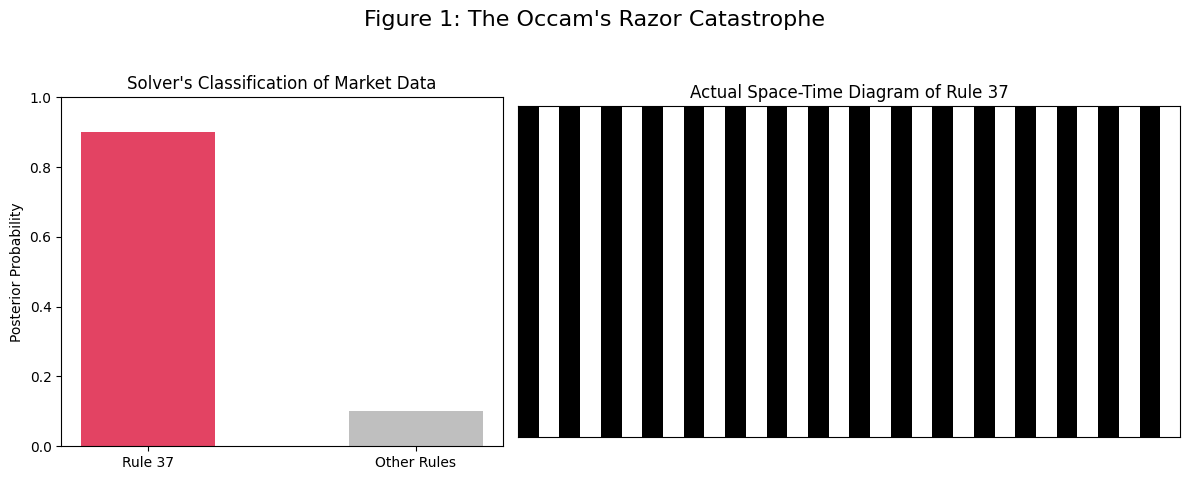

In [2]:
# @title Cell 2: Evidence for Section 2: "The Rule 37 Delusion" Figure
# ==============================================================================
# This cell generates the illustrative figure for the "Occam's Razor Catastrophe."
# This is a conceptual, not computational, figure.

def plot_rule37_delusion():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle("Figure 1: The Occam's Razor Catastrophe", fontsize=16)

    # Left Panel: The Solver's Confidence
    ax1.bar(['Rule 37'], [0.9], color='crimson', alpha=0.8, width=0.5)
    ax1.bar(['Other Rules'], [0.1], color='gray', alpha=0.5, width=0.5)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("Posterior Probability")
    ax1.set_title("Solver's Classification of Market Data")
    ax1.text(0, 0.92, '90%', ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

    # Right Panel: Rule 37's Actual Pattern
    size = 32
    rule37_pattern = np.zeros((size, size*2), dtype=int)
    for i in range(size*2):
        if (i // 2) % 2 == 0:
            rule37_pattern[:, i] = 1

    ax2.imshow(rule37_pattern, cmap='binary', interpolation='nearest')
    ax2.set_title("Actual Space-Time Diagram of Rule 37")
    ax2.set_xticks([])
    ax2.set_yticks([])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("--- Generating Figure for Section 2 ---")
plot_rule37_delusion()

In [3]:
# @title Cell 3: Evidence for Section 3: "Microscope Failure" Table
# ==============================================================================
# This cell reproduces the full "Microscope vs. Stethoscope" experiment (Prototype 2.1)
# and generates the definitive table for Section 3 of the paper.

# --- 1. Configuration and Data ---
class Config_Exp2:
    START_DATE = "2018-07-01"
    END_DATE = "2019-03-31"
    TICKERS = ['AAPL', 'BA', 'CAT', 'DIS', 'GE', 'IBM', 'MSFT', 'TSLA']

print("--- Running Experiment for Section 3 ---")
print("Fetching data for Q4 2018 window...")
price_data = yf.download(Config_Exp2.TICKERS,
                           start=Config_Exp2.START_DATE,
                           end=Config_Exp2.END_DATE,
                           auto_adjust=True,
                           progress=False)['Close'].dropna()
multivariate_pct_change = price_data.pct_change().dropna() * 100
market_index = multivariate_pct_change.mean(axis=1)
print("✅ Data ready.")

# --- 2. MDL Detector Implementations ---
def find_best_break_point_gaussian(series):
    # (Same implementation as main notebook)
    def mdl_cost_gaussian(segment):
        n = len(segment)
        if n < 2: return np.inf
        mean = np.mean(segment); variance = np.var(segment, ddof=1)
        if variance == 0: variance = 1e-9
        model_cost = 2 * np.log(n); log_likelihood = -np.sum((segment - mean)**2) / (2 * variance) - n/2 * np.log(2 * np.pi * variance)
        return model_cost - log_likelihood
    n_total = len(series); min_segment_len = 15; cost_h0 = mdl_cost_gaussian(series)
    min_h1_cost = np.inf; best_break_date = None
    for k in range(min_segment_len, n_total - min_segment_len):
        cost_h1 = mdl_cost_gaussian(series.iloc[:k]) + mdl_cost_gaussian(series.iloc[k:])
        if cost_h1 < min_h1_cost: min_h1_cost = cost_h1; best_break_date = series.index[k]
    return {"break_date": best_break_date, "mdl_cost_saving_nats": cost_h0 - min_h1_cost}

def find_best_break_point_var(dataframe):
    # (Same implementation as previous prototype)
    def mdl_cost_var(segment_df):
        n, K = segment_df.shape
        if n <= K: return np.inf
        try:
            results = VAR(segment_df).fit(1, trend='c')
        except Exception: return np.inf
        num_params = K**2 * 1 + K; model_cost = num_params * np.log(n)
        data_cost = -results.llf; return model_cost + data_cost
    n_total = len(dataframe); min_segment_len = 20; cost_h0 = mdl_cost_var(dataframe)
    min_h1_cost = np.inf; best_break_date = None
    for k in tqdm(range(min_segment_len, n_total - min_segment_len), desc="Scanning (VAR)"):
        cost_h1 = mdl_cost_var(dataframe.iloc[:k]) + mdl_cost_var(dataframe.iloc[k:])
        if cost_h1 < min_h1_cost: min_h1_cost = cost_h1; best_break_date = dataframe.index[k]
    return {"break_date": best_break_date, "mdl_cost_saving_nats": cost_h0 - min_h1_cost}

def find_best_break_point_covariance(dataframe):
    # (Same implementation as previous prototype)
    def mdl_cost_covariance(segment_df):
        n, K = segment_df.shape
        if n <= K: return np.inf
        S = segment_df.cov(); num_params = K * (K + 1) / 2; model_cost = num_params * np.log(n)
        try:
            sign, logdet = np.linalg.slogdet(S)
            if sign != 1: return np.inf
            log_likelihood = - (n/2) * (K * np.log(2 * np.pi) + logdet + K)
        except np.linalg.LinAlgError: return np.inf
        data_cost = -log_likelihood; return model_cost + data_cost
    n_total = len(dataframe); min_segment_len = 20; cost_h0 = mdl_cost_covariance(dataframe)
    min_h1_cost = np.inf; best_break_date = None
    for k in tqdm(range(min_segment_len, n_total - min_segment_len), desc="Scanning (Covariance)"):
        cost_h1 = mdl_cost_covariance(dataframe.iloc[:k]) + mdl_cost_covariance(dataframe.iloc[k:])
        if cost_h1 < min_h1_cost: min_h1_cost = cost_h1; best_break_date = dataframe.index[k]
    return {"break_date": best_break_date, "mdl_cost_saving_nats": cost_h0 - min_h1_cost}

# --- 3. Run All Analyses ---
print("Running 'Stethoscope'...")
res_steth = find_best_break_point_gaussian(market_index)
print("Running 'Microscope (VAR)'...")
res_var = find_best_break_point_var(multivariate_pct_change)
print("Running 'Microscope (Covariance)'...")
res_cov = find_best_break_point_covariance(multivariate_pct_change)

# --- 4. Display Final Markdown Table ---
print("\n" + "="*80)
print("                  TABLE FOR SECTION 3: 'Microscope' Failure")
print("="*80)
print("| Approach                            | MDL Cost Saving (bits) | Detected Break Date |")
print("|:------------------------------------|:----------------------:|:-------------------:|")
print(f"| Stethoscope (MDL/Gaussian on Index) | **+{res_steth['mdl_cost_saving_nats']/np.log(2):.1f}**              | **{pd.to_datetime(res_steth['break_date']).date()}**      |")
print(f"| Microscope (MDL/VAR)                | {res_var['mdl_cost_saving_nats']/np.log(2):.1f}                  | {pd.to_datetime(res_var['break_date']).date()}          |")
print(f"| Microscope (MDL/Covariance)         | {res_cov['mdl_cost_saving_nats']/np.log(2):.1f}                  | {pd.to_datetime(res_cov['break_date']).date()}          |")

--- Running Experiment for Section 3 ---
Fetching data for Q4 2018 window...
✅ Data ready.
Running 'Stethoscope'...
Running 'Microscope (VAR)'...


Scanning (VAR):   0%|          | 0/146 [00:00<?, ?it/s]

Running 'Microscope (Covariance)'...


Scanning (Covariance):   0%|          | 0/146 [00:00<?, ?it/s]


                  TABLE FOR SECTION 3: 'Microscope' Failure
| Approach                            | MDL Cost Saving (bits) | Detected Break Date |
|:------------------------------------|:----------------------:|:-------------------:|
| Stethoscope (MDL/Gaussian on Index) | **+11.7**              | **2018-09-28**      |
| Microscope (MDL/VAR)                | -39.4                  | 2018-08-01          |
| Microscope (MDL/Covariance)         | -65.0                  | 2019-02-27          |
